<a href="https://colab.research.google.com/github/shilz1007/shilz1007/blob/main/3D_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 659 kB 5.1 MB/s 


In [2]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Model,activations
from tensorflow.keras.layers import Activation,Dense,Flatten,Conv1D,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

Downloading ModelNet10 dataset.

In [3]:
Data_ModelNet = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)                        
Data_ModelNet = os.path.join(os.path.dirname(Data_ModelNet), "ModelNet10")                                        

473402300/473402300 [==============================] - 9s 0us/step


In [41]:
mesh = trimesh.load(os.path.join(Data_ModelNet,"chair/train/chair_0370.off"))
mesh.show()

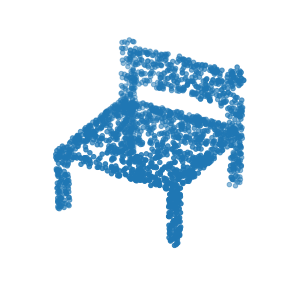

In [42]:
points = mesh.sample(2048)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [43]:
def create_test_train(num_points=2048):
  print('inside')
  train_points = []
  train_labels = []
  test_points  = []
  test_labels  = []
  class_map = {}
  folders = glob.glob(os.path.join(Data_ModelNet,"[!README]*"))
  #print(folders)

  for i, folder in enumerate(folders):
    #print("processing class: {}".format(os.path.basename(folder)))
    class_map[i] = folder.split("/")[-1]
    #print(class_map[i])
    train_files = glob.glob(os.path.join(folder,"train/*"))
    test_files = glob.glob(os.path.join(folder,"test/*"))

    for f in train_files:
      train_points.append(trimesh.load(f).sample(num_points))
      train_labels.append(i)

    for f in test_files:
      test_points.append(trimesh.load(f).sample(num_points))
      test_labels.append(i)

  print(class_map)
  return(
      np.array(train_points),
      np.array(test_points),
      np.array(train_labels),
      np.array(test_labels),
      class_map,
  )      

In [44]:
points = 2048
classes = 10
batch_size = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = create_test_train(points)

inside


KeyboardInterrupt: ignored

In [22]:
for i in range(10):
  print(CLASS_MAP[i])

toilet
chair
night_stand
table
bathtub
sofa
dresser
monitor
bed
desk


In [39]:
#for i in range(3991):
#    print(train_labels[i])

train_labels[380]    

1

In [ ]:
def augment(points,labels):
  points += tf.random.uniform(points.shape,-0.005,0.005,dtype=tf.float64)
  points = tf.random.shuffle(points)
  return points,labels

train_dataset = tf.data.Dataset.from_tensor_slices((train_points,train_labels))
test_dataset =  tf.data.Dataset.from_tensor_slices((test_points,test_labels))

#train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(batch_size)
train_dataset = train_dataset.shuffle(len(train_points)).batch(batch_size)
test_dataset = test_dataset.shuffle(len(test_points)).batch(batch_size)

Model

In [ ]:
inputs = tf.keras.Input(shape=(points,3))
pointnet = Sequential()
pointnet = tf.keras.layers.Conv1D(32,kernel_size=1,padding='valid')(inputs)
pointnet = tf.keras.layers.BatchNormalization()(pointnet)
pointnet = tf.keras.layers.Activation('relu')(pointnet)
pointnet = tf.keras.layers.Conv1D(64,kernel_size=1,padding='valid')(pointnet)
pointnet = tf.keras.layers.BatchNormalization()(pointnet)
pointnet = tf.keras.layers.Activation('relu')(pointnet)
pointnet = tf.keras.layers.Conv1D(512,kernel_size=1,padding='valid')(pointnet)
pointnet = tf.keras.layers.BatchNormalization()(pointnet)
pointnet = tf.keras.layers.Activation('relu')(pointnet)
pointnet = tf.keras.layers.GlobalMaxPool1D()(pointnet)
pointnet = tf.keras.layers.Flatten()(pointnet)
pointnet = tf.keras.layers.Dense(256,activation='relu')(pointnet)
pointnet = tf.keras.layers.Dropout(0.3)(pointnet)
pointnet = tf.keras.layers.Dense(128,activation='relu')(pointnet)
pointnet = tf.keras.layers.Dropout(0.3)(pointnet)

outputs = tf.keras.layers.Dense(classes,activation='softmax')(pointnet)
model = tf.keras.Model(inputs=inputs,outputs=outputs,name='pointnet')
model.summary()


Model: "pointnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2048, 3)]         0         
                                                                 
 conv1d_16 (Conv1D)          (None, 2048, 32)          128       
                                                                 
 batch_normalization_16 (Bat  (None, 2048, 32)         128       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 2048, 32)          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 2048, 64)          2112      
                                                                 
 batch_normalization_17 (Bat  (None, 2048, 64)         256       
 chNormalization)                                         

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=["sparse_categorical_accuracy"])


In [ ]:
model.fit(train_dataset,epochs=50,validation_data=test_dataset)

Epoch 1/50
125/125 [==============================] - 8s 52ms/step - loss: 2.1397 - sparse_categorical_accuracy: 0.3325 - val_loss: 2.3188 - val_sparse_categorical_accuracy: 0.1311
Epoch 2/50
125/125 [==============================] - 6s 50ms/step - loss: 1.4853 - sparse_categorical_accuracy: 0.5001 - val_loss: 2.7529 - val_sparse_categorical_accuracy: 0.1344
Epoch 3/50
125/125 [==============================] - 6s 50ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.5876 - val_loss: 2.9149 - val_sparse_categorical_accuracy: 0.1421
Epoch 4/50
125/125 [==============================] - 6s 50ms/step - loss: 1.1061 - sparse_categorical_accuracy: 0.6229 - val_loss: 2.5917 - val_sparse_categorical_accuracy: 0.1586
Epoch 5/50
125/125 [==============================] - 6s 50ms/step - loss: 0.9911 - sparse_categorical_accuracy: 0.6678 - val_loss: 2.8808 - val_sparse_categorical_accuracy: 0.1498
Epoch 6/50
125/125 [==============================] - 6s 50ms/step - loss: 0.9759 - sparse_cate

1/1 [==============================] - 0s 17ms/step


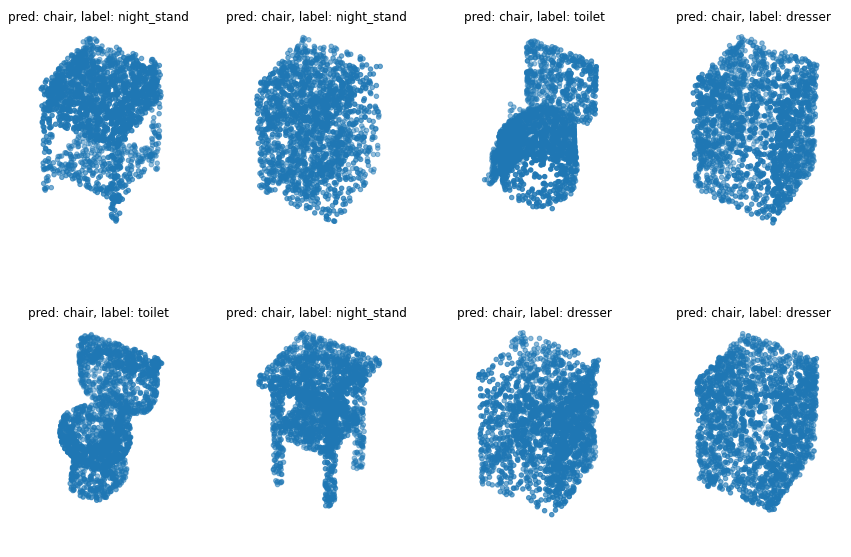

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()